In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [26]:
df.isnull().sum()

holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64

In [27]:
df.drop('holiday',axis=1, inplace=True)
df.head()

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [28]:
#Convert DateTime and Extract Features
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day'] = df['date_time'].dt.day
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year

# Drop the original 'date_time' column
df = df.drop(columns=['date_time'])

In [29]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,day,month,year
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355,11.398162,15.737636,6.506037,2015.512426
std,13.338232,44.789133,0.008168,39.015750,1986.860670,6.940238,8.722938,3.400221,1.893211
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2012.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000,5.000000,8.000000,4.000000,2014.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000,11.000000,16.000000,7.000000,2016.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000,17.000000,23.000000,9.000000,2017.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000,23.000000,31.000000,12.000000,2018.000000


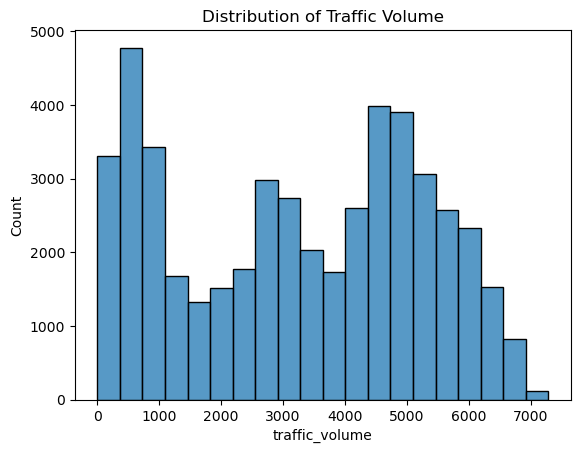

In [30]:
sns.histplot(df['traffic_volume'], bins=20)
plt.title('Distribution of Traffic Volume')
plt.show()

In [31]:
df['traffic_volume'].mean()

3259.8183553232097

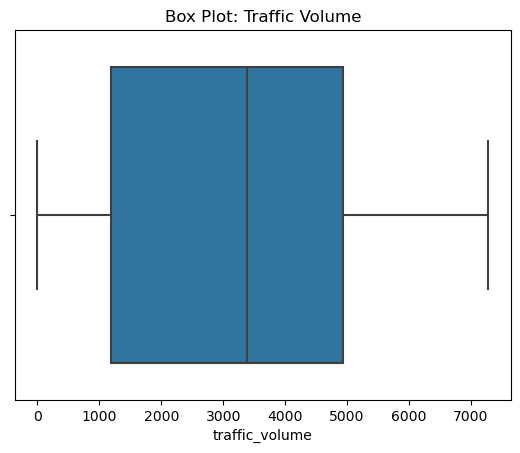

Number of Outliers: 0
Empty DataFrame
Columns: [temp, rain_1h, snow_1h, clouds_all, weather_main, weather_description, traffic_volume, hour, day, month, year]
Index: []


In [32]:
# outliers
from scipy import stats
sns.boxplot(x=df['traffic_volume'])
plt.title('Box Plot: Traffic Volume')
plt.show()

# Identify outliers using Z-score
z_scores = np.abs(stats.zscore(df['traffic_volume']))
outliers = df[(z_scores >= 3) | (z_scores <= -3)]

# Print or analyze the outliers as needed
print(f'Number of Outliers: {len(outliers)}')
print(outliers)

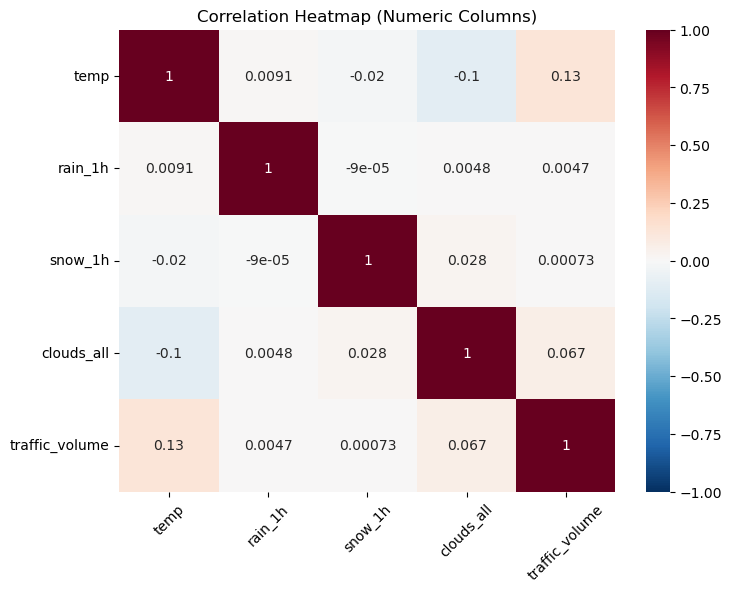

In [33]:
# Select only the numeric columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix for the numeric columns
corr_matrix = df[num_cols].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Numeric Columns)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [34]:
# One-hot encode the 'weather_main' and 'weather_description' columns
df = pd.get_dummies(df, columns=['weather_main', 'weather_description'], drop_first=True)

In [35]:
features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'hour', 'day', 'month', 'year']
target = 'traffic_volume'

In [36]:
#Normalize the Data
from sklearn.preprocessing import MinMaxScaler
# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Apply scaling
df[features] = scaler_X.fit_transform(df[features])
df[[target]] = scaler_y.fit_transform(df[[target]])

In [40]:
#Prepare Data for Time Series Modeling
# Define the number of previous timesteps to consider
timesteps = 24  

# Prepare the sequences for LSTM
def create_sequences(df, features, target, timesteps):
    X, y = [], []
    for i in range(timesteps, len(df)):
        X.append(df[features].iloc[i-timesteps:i].values)
        y.append(df[target].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df, features, target, timesteps)

# Reshape y to be a 2D array (samples, 1)
y = y.reshape(-1, 1)

In [41]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [42]:
# Building the LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Define the LSTM model
model = Sequential()

# Add LSTM layers with Dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1))



/Users/mariyayousef/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - loss: 0.0572 - val_loss: 0.0273
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - loss: 0.0339 - val_loss: 0.0250
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0284 - val_loss: 0.0223
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - loss: 0.0268 - val_loss: 0.0214
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - loss: 0.0251 - val_loss: 0.0210
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - loss: 0.0237 - val_loss: 0.0201
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - loss: 0.0223 - val_loss: 0.0196
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - loss: 0.0224 - val_loss: 0.0191
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - loss: 0.0214 - val_loss: 0.0189
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - loss: 0.0214 - val_loss: 0.0187


In [45]:
#Evaluate the Model

# Predict on the test set
y_pred = model.predict(X_test)

# Inverse scale the predictions and true values
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler_y.inverse_transform(y_pred)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
RMSE: 996.1544965982981


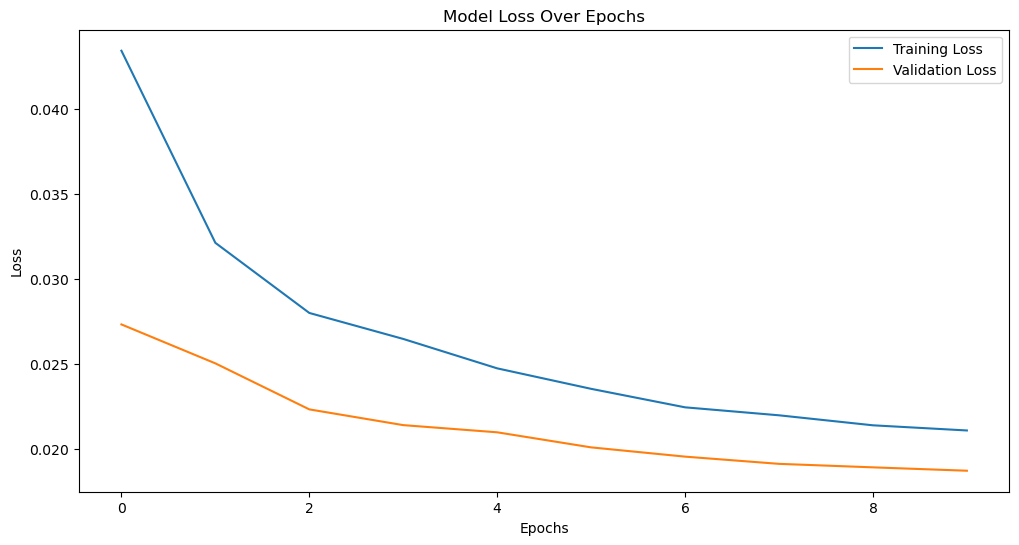

In [46]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

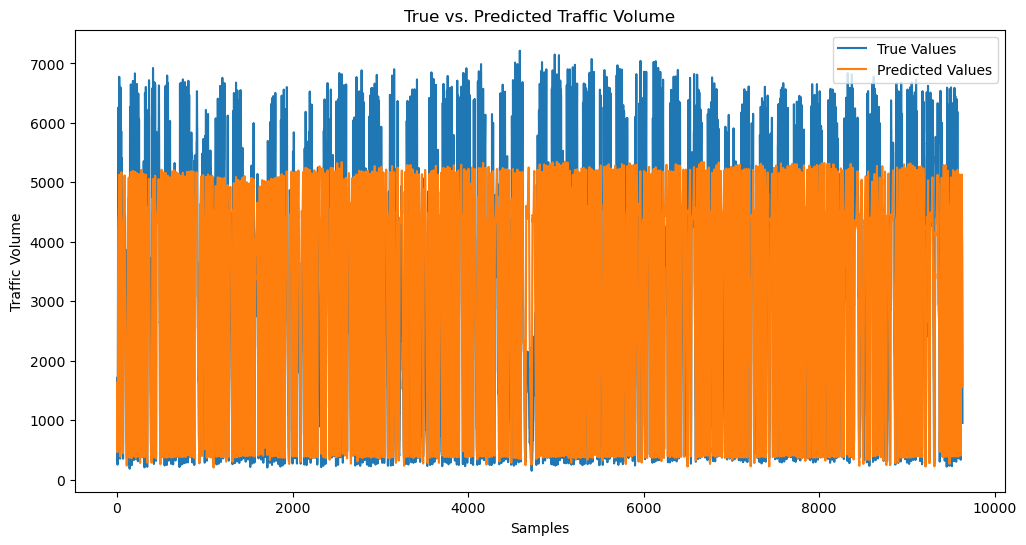

In [47]:
#Plot Predicted vs. True Values
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Plot predictions vs. true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label='True Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title('True vs. Predicted Traffic Volume')
plt.xlabel('Samples')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()